<a href="https://colab.research.google.com/github/sivagunturi/mfr_meta/blob/main/latest_triplet_loss_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown
!pip install opencv-python==4.4.0.44
!pip install tensorflow-addons==0.10.0
!pip install trianglesolver==1.2
!pip uninstall imgaug
!pip install imgaug==0.2.5
!pip install mtcnn
!pip install dotmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installa

In [2]:
from distutils.dir_util import copy_tree
from google.colab.patches import cv2_imshow
from numpy import load
from os.path import exists
from pathlib import Path
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import (array_to_img, img_to_array,  load_img)
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import shutil
import skimage.io as io
import subprocess
import sys
import tarfile
import tensorflow as tf
import time
import zipfile
tf.__version__, np.__version__

('2.8.2', '1.21.6')

In [3]:
tf.test.gpu_device_name()
MFR_REPO_COLAB_PATH='/content/mfr_meta'
MFR_REPO_GIT_PATH = 'https://github.com/sivagunturi/mfr_meta.git'
STRV_REPO_COLAB_PATH = "/content/strv"
STRV_REPO_GIT_PATH = 'https://github.com/sivagunturi/strv.git'
MTF_REPO_COLAB_PATH="/content/MaskTheFace"
MTF_REPO_GIT_PATH="https://github.com/aqeelanwar/MaskTheFace"
MTF_MODEL_NAME =  "model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5"

In [4]:
yorn = input ("Force delete all code directpries (y/n)") 
if(yorn == 'y'):
  os.chdir("/")
  if(os.path.isdir(MFR_REPO_COLAB_PATH) == True):
    shutil.rmtree(MFR_REPO_COLAB_PATH)
  if(os.path.isdir(STRV_REPO_COLAB_PATH) == True):
    shutil.rmtree(STRV_REPO_COLAB_PATH)
  if(os.path.isdir(MTF_REPO_GIT_PATH) == True): 
    shutil.rmtree(MTF_REPO_GIT_PATH)

Force delete all code directpries (y/n)y


In [5]:
def clone_repo_install_dependencies(repo_path, git_path):
  if(os.path.isdir(repo_path) == False):
    os.chdir('/content')
    results = subprocess.run(["git", "clone", git_path], capture_output=True)
    print(results)
    # os.chdir(repo_path)
    # subprocess.run(["pip", "install",'-r', "requirements.txt"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    return True
  return False

In [6]:
mfr_install = clone_repo_install_dependencies(MFR_REPO_COLAB_PATH, MFR_REPO_GIT_PATH)
strv_install = clone_repo_install_dependencies(STRV_REPO_COLAB_PATH, STRV_REPO_GIT_PATH)
mtf_install = clone_repo_install_dependencies(MTF_REPO_COLAB_PATH, MTF_REPO_GIT_PATH)
# if(mfr_install or strv_install or mtf_install):
#   os.kill(os.getpid(), 9)

CompletedProcess(args=['git', 'clone', 'https://github.com/sivagunturi/mfr_meta.git'], returncode=0, stdout=b'', stderr=b"Cloning into 'mfr_meta'...\n")
CompletedProcess(args=['git', 'clone', 'https://github.com/sivagunturi/strv.git'], returncode=0, stdout=b'', stderr=b"Cloning into 'strv'...\n")
CompletedProcess(args=['git', 'clone', 'https://github.com/aqeelanwar/MaskTheFace'], returncode=0, stdout=b'', stderr=b"Cloning into 'MaskTheFace'...\n")


In [7]:
ls /content/

MaskTheFace/  mfr_meta/  sample_data/  strv/


In [8]:
os.chdir(STRV_REPO_COLAB_PATH)

In [9]:
from utils import download_data
from utils.architectures import UNet
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.model import Mask2FaceModel

In [10]:
def download_from_drive(id, output_file, unzip=False):
  results = subprocess.run(["gdown", "--id", id, "--output", output_file], capture_output=True)
  print(results)
  if(unzip):
    subprocess.run(["unzip", output_file], capture_output=True)
    print(results)

In [11]:
download_from_drive("1egNNyrOv1Xdio8peNla1QDVBSIDu-Fjv", "model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5")
download_from_drive("1iWqF8dWpDPZbciufcUyPuprLfcP4Zs4w", "data.zip", unzip=True)

CompletedProcess(args=['gdown', '--id', '1egNNyrOv1Xdio8peNla1QDVBSIDu-Fjv', '--output', 'model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5'], returncode=0, stdout=b'', stderr=b"/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.\n  category=FutureWarning,\nDownloading...\nFrom: https://drive.google.com/uc?id=1egNNyrOv1Xdio8peNla1QDVBSIDu-Fjv\nTo: /content/strv/model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5\n\r  0%|          | 0.00/643M [00:00<?, ?B/s]\r  1%|          | 4.72M/643M [00:00<00:19, 33.4MB/s]\r  4%|\xe2\x96\x8d         | 28.8M/643M [00:00<00:04, 137MB/s] \r  8%|\xe2\x96\x8a         | 50.9M/643M [00:00<00:04, 130MB/s]\r 13%|\xe2\x96\x88\xe2\x96\x8e        | 84.4M/643M [00:00<00:03, 179MB/s]\r 17%|\xe2\x96\x88\xe2\x96\x8b        | 107M/643M [00:00<00:02, 193MB/s] \r 20%|\xe2\x96\x88\xe2\x96\x89        

In [12]:
configuration = Configuration()
# Feel free to experiment with the number of filters, their sizes or any other parameters
if(exists(MTF_MODEL_NAME) == False):
  filters = (64, 128, 128, 256, 256, 512)
  kernels = (7, 7, 7, 3, 3, 3)
  input_image_size = (256, 256, 3)
  architecture = UNet.RESNET
  training_epochs = 20
  batch_size = 12

  # Create instance of model and start training
  model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                    kernels=kernels, configuration=configuration)
  model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

  model.compute_output_shape(input_shape=(None, 256,256,3))
else:
  trained_model = Mask2FaceModel.load_model('model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5')

In [13]:
ls -l /content/strv

total 2777300
-rw-r--r-- 1 root root        887 Jun  7 14:35 configuration.json
drwxr-xr-x 4 root root       4096 May 18 02:26 data/
-rw-r--r-- 1 root root 2199292924 Jun  7 14:36 data.zip
-rw-r--r-- 1 root root        515 Jun  7 14:35 environment.yml
drwxr-xr-x 2 root root       4096 Jun  7 14:35 images/
-rw-r--r-- 1 root root       1061 Jun  7 14:35 LICENSE
-rw-r--r-- 1 root root    1119200 Jun  7 14:35 mask2face.ipynb
drwxr-xr-x 4 root root       4096 Jun  7 14:35 masks/
drwxr-xr-x 3 root root       4096 Jun  7 14:35 mask_utils/
-rw-r--r-- 1 root root  643488272 Jun  7 14:35 model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5
-rw-r--r-- 1 root root       3575 Jun  7 14:35 README.md
-rw-r--r-- 1 root root         85 Jun  7 14:35 requirements.txt
drwxr-xr-x 3 root root       4096 Jun  7 14:35 utils/


In [20]:
! ls /content/strv

configuration.json
data
data.zip
environment.yml
images
LICENSE
mask2face.ipynb
masks
mask_utils
model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5
README.md
requirements.txt
utils


In [21]:
  trained_model = Mask2FaceModel.load_model('/content/strv/model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5')

  0%|          | 0/64040097 [00:00<?, ?it/s]

Decompressing downloaded file into shape_predictor_68_face_landmarks.dat
Here are few examples of generated data.


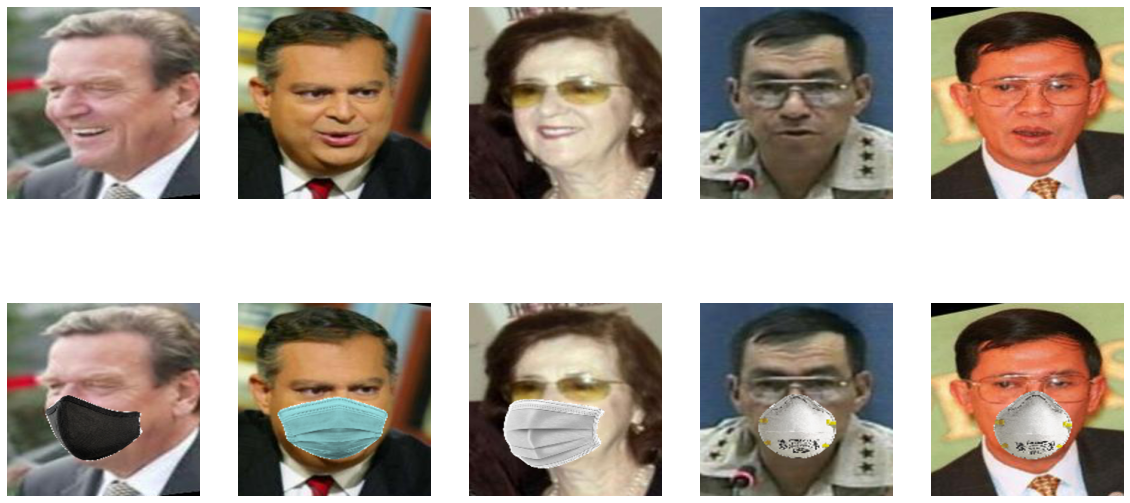

In [22]:
# setup the pipeline and generate data
configuration = Configuration()
dg = DataGenerator(configuration)  
train_folder = configuration.get('train_data_path')
test_folder = configuration.get('test_data_path')
if(exists(MTF_MODEL_NAME) == False):
  if os.path.exists(train_folder) and os.path.exists(test_folder):
      print('Testing and training data already generated')
  else:
    dg.generate_images()

print('Here are few examples of generated data.')
n_examples = 5
inputs, outputs = dg.get_dataset_examples(n_examples)
f, axarr = plt.subplots(2, n_examples, figsize=(20, 10))
for i in range(len(inputs)):
    axarr[1, i].imshow(mpimg.imread(inputs[i]))
    axarr[1, i].axis('off')
    axarr[0, i].imshow(mpimg.imread(outputs[i]))
    axarr[0, i].axis('off')

In [23]:
# Check if dataset is already downloaded or needs to be downloaded.
configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if(exists(MTF_MODEL_NAME) == False):
  if os.path.isdir(dataset_path):
      print('Dataset already downloaded')
  else:
      print('Downloading dataset')
      print('Downloading dataset')
      dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
      download_data('http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz', dataset_archive_path)
      print('Extracting dataset')
      tar = tarfile.open(dataset_archive_path, 'r:gz')
      tar.extractall('data')
      tar.close()
      print('Done')

In [24]:
INPUT_IMAGE_SHAPE= 224
force_create = True

In [25]:

if(force_create == True):
  if(os.path.isdir('/tmp/dataset') == True):
    subprocess.run(["rm", "-rf", "/tmp/dataset"])
  # if(os.path.isdir('/tmp/lfw') == True):
  #   subprocess.run(["rm", "-rf", "/tmp/lfw"])
  # if(os.path.isdir('/tmp/mlfw') == True):
  #   subprocess.run(["rm", "-rf", "/tmp/mlfw"])


In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
def extract_lfw_mlfw():
  if(os.path.isdir('/tmp/lfw') == False):
    cmd = "tar -xvf /content/gdrive/MyDrive/datasets/lfw.tar -C /tmp/"
    returned_value = os.system(cmd)
  if(os.path.isdir('/tmp/lfw-deepfunneled') == True):
    os.rename('/tmp/lfw-deepfunneled','/tmp/lfw')

  if(os.path.isdir('/tmp/mlfw/')== False):
    zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/datasets/MLFW.zip", 'r')
    zip_ref.extractall("/tmp/mlfw/")
    zip_ref.close()

In [28]:
def pick_images_lfw():
  lfw_images = []
  lfw_train = sorted(os.listdir("/tmp/lfw/"))
  for directory in lfw_train:
    dir_path = "/tmp/lfw/" + directory
    no_of_files = len(os.listdir(dir_path)) 
    if(no_of_files >= 3 and no_of_files <= 5):
      lfw_images.append(directory)
  return lfw_images;

In [29]:
def create_common_dir_list():
  extract_lfw_mlfw();
  lfw_dir = pick_images_lfw();
  mlfw_dir = pick_images_mlfw()
  common_set = set(lfw_dir) & set(mlfw_dir)
  return list(common_set)

In [30]:
def pick_images_mlfw():
  file_list = glob.glob("/tmp/mlfw/origin/*.jpg")
  final_name_list = []
  for file in file_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str)  
  print(len(set(final_name_list)))
  df = pd.DataFrame(final_name_list)
  df.columns = ['name']
  new_df = df.groupby('name').filter(lambda x : (len(x) >= 3 and len(x) <= 5))
  mlfw_images = new_df.values.tolist()
  mlfw_images = [sub[0][ : -1] for sub in mlfw_images]
  return list(set(mlfw_images))


In [31]:
def pick_classes(no_of_classes):
  final_list = []
  filtered_list =  create_common_dir_list()
  print("filtered_list_length = " + str(len(filtered_list)))
  for i in range(0, no_of_classes):
      final_list.append(random.choice(filtered_list))
  return final_list

In [32]:
def create_train_test_set_from_lfw_mlfw():
  final_class_list = pick_classes(100)
  print(final_class_list)
  if(os.path.isdir('/tmp/dataset/train') == True):
    shutil.rmtree('/tmp/dataset/train')
  if(os.path.isdir('/tmp/dataset/test') == True):
    shutil.rmtree('/tmp/dataset/test')
  if(os.path.isdir('/tmp/dataset/')  == False):
    os.mkdir('/tmp/dataset/')
  if(os.path.isdir('/tmp/dataset/train')== False):
    os.mkdir('/tmp/dataset/train')
  if(os.path.isdir('/tmp/dataset/test')== False):
    os.mkdir('/tmp/dataset/test')

  for dir in final_class_list:  
    os.system("cp -r " + " /tmp/lfw/"+ dir + " /tmp/dataset/train")
  
  mlfw_jpg_list = []
  for path, subdirs, files in os.walk('/tmp/mlfw/aligned/'):
      for name in files:
          mlfw_jpg_list.append(os.path.join(path, name))

  for dir in final_class_list:
    if(os.path.isdir('/tmp/dataset/test/'+dir)  == False):
      os.mkdir('/tmp/dataset/test/'+dir)
    name_list = [k for k in mlfw_jpg_list if dir in k]
    for nme in name_list:
      shutil.copy(nme, "/tmp/dataset/test/"+dir + "/")

In [33]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from mtcnn.mtcnn import MTCNN
from numpy import asarray
import cv2
from PIL import Image
!pip install imagesize
import imagesize
# extract a single face from a given photograph
def process_face(filename, required_size=(INPUT_IMAGE_SHAPE, INPUT_IMAGE_SHAPE)):
  # # load image from file
  # image = Image.open(filename)
  # # # convert to RGB, if needed
  # # image = image.convert('RGB')
  # # convert to array
  # pixels = asarray(image)
  # # create the detector, using default weights
  # detector = MTCNN()
  # # detect faces in the image
  # results = detector.detect_faces(pixels)
  # if(results):
  #   # extract the bounding box from the first face
  #   x1, y1, width, height = results[0]['box']
  #   # bug fix
  #   x1, y1 = abs(x1), abs(y1)
  #   x2, y2 = x1 + width, y1 + height
  #   # extract the face
  #   face = pixels[y1:y2, x1:x2]
  #   # resize pixels to the model size
  #   image = Image.fromarray(face)
  #   image = image.resize(required_size)
  #   face_array = asarray(image)
  #   cv2.imwrite(filename, face_array)
  #   new_size = imagesize.get(filename)
   # load image from file
  image = Image.open(filename)
  # convert to RGB, if needed
  # image = cv2.imread(filename)
  if(image.width != required_size[0]):
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    if(results):
      # extract the bounding box from the first face
      x1, y1, width, height = results[0]['box']
      # bug fix
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      # extract the face
      # image = image[y1:y2, x1:x2]
      facepixels = pixels[y1:y2, x1:x2]
      # resize pixels to the model size
      image = Image.fromarray(facepixels)
      # image = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      image = image.resize(required_size)
      # cv2.resize(image, required_size)
      # face_array = asarray(image)
      # cv2.imwrite(filename, image)
      # print('processed and saved file', filename)
      image.save(filename)
    new_size = image.size
    print("image size", new_size)
    if(new_size[0] != INPUT_IMAGE_SHAPE):
      print("deleted image size", filename,new_size)
      os.remove(filename)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
ls -l /tmp

total 52
-rw-r--r-- 1 root root 1165 Jun  7 14:33 dap_multiplexer.0a504e4cb8b5.root.log.INFO.20220607-143307.61
lrwxrwxrwx 1 root root   61 Jun  7 14:33 dap_multiplexer.INFO -> dap_multiplexer.0a504e4cb8b5.root.log.INFO.20220607-143307.61
srwxr-xr-x 1 root root    0 Jun  7 14:33 debugger_6wfdbac4j=
-rw-r--r-- 1 root root 1648 Jun  7 14:38 directoryprefetcher_binary.0a504e4cb8b5.root.log.INFO.20220607-143852.597
lrwxrwxrwx 1 root root   73 Jun  7 14:38 directoryprefetcher_binary.INFO -> directoryprefetcher_binary.0a504e4cb8b5.root.log.INFO.20220607-143852.597
srw------- 1 root root    0 Jun  7 14:38 drivefs_ipc.0=
srw------- 1 root root    0 Jun  7 14:38 drivefs_ipc.0_shell=
drwx------ 2 root root 4096 Jun  7 14:38 initgoogle_syslog_dir.0/
drwx------ 2 root root 4096 Jun  7 14:34 pyright-142-eR9uBoAt9WC2/
drwx------ 2 root root 4096 Jun  7 14:34 pyright-142-FtFUsdEn4iu1/
drwx------ 2 root root 4096 Jun  7 14:34 pyright-196-KA2KE9kfvE3A/
drwx------ 2 root root 4096 Jun  7 14:34 pyright-1

In [36]:
def get_image_list_from_folder(path):
  final_list = []
  for path, subdirs, files in os.walk(path):
    for name in files:
        final_list.append(os.path.join(path, name))
  return sorted(final_list)

def process_faces(image_list):
  for file in image_list:
    process_face(file)

In [37]:
def plot_images(w, h, fig_w, fig_h, image_list, columns, rows):
  fig = plt.figure(figsize=(fig_w, fig_h))
  for i in range(1, columns*rows +1):
      img = mpimg.imread(image_list[i])
      fig.add_subplot(rows, columns, i)
      plt.title(os.path.basename(image_list[i]))
      plt.imshow(img)
  plt.show()

In [38]:
if(force_create == True):
  create_train_test_set_from_lfw_mlfw()

2996
filtered_list_length = 156
['Edmund_Hillary', 'Vladimiro_Montesinos', 'Hitomi_Soga', 'Dean_Barkley', 'Derek_Jeter', 'Candice_Bergen', 'Branko_Crvenkovski', 'Gary_Doer', 'Carlos_Ruiz', 'Ranil_Wickremasinghe', 'Muhammad_Saeed_al-Sahhaf', 'Dale_Earnhardt_Jr', 'Sourav_Ganguly', 'Mikhail_Youzhny', 'Prince_Claus', 'Vincent_Gallo', 'Bridgette_Wilson-Sampras', 'Ronaldo_Luis_Nazario_de_Lima', 'Pupi_Avati', 'Dean_Barkley', 'Cecilia_Bolocco', 'Coretta_Scott_King', 'Jose_Canseco', 'Rod_Stewart', 'Angelo_Reyes', 'Federico_Trillo', 'Fred_Thompson', 'Iain_Duncan_Smith', 'Vitali_Klitschko', 'Ronald_Reagan', 'Monica_Lewinsky', 'Filippo_Inzaghi', 'Samuel_Waksal', 'James_Cunningham', 'LeBron_James', 'Christine_Baumgartner', 'Ethan_Hawke', 'Zoran_Djindjic', 'Joseph_Biden', 'Woody_Allen', 'Toni_Braxton', 'Art_Howe', 'John_Reid', 'Steve_Nash', 'Mike_Tyson', 'Vitali_Klitschko', 'Jesse_Ventura', 'James_Traficant', 'Sally_Kirkland', 'Federico_Trillo', 'Paul_Shanley', 'Muhammad_Saeed_al-Sahhaf', 'Dean_Bark

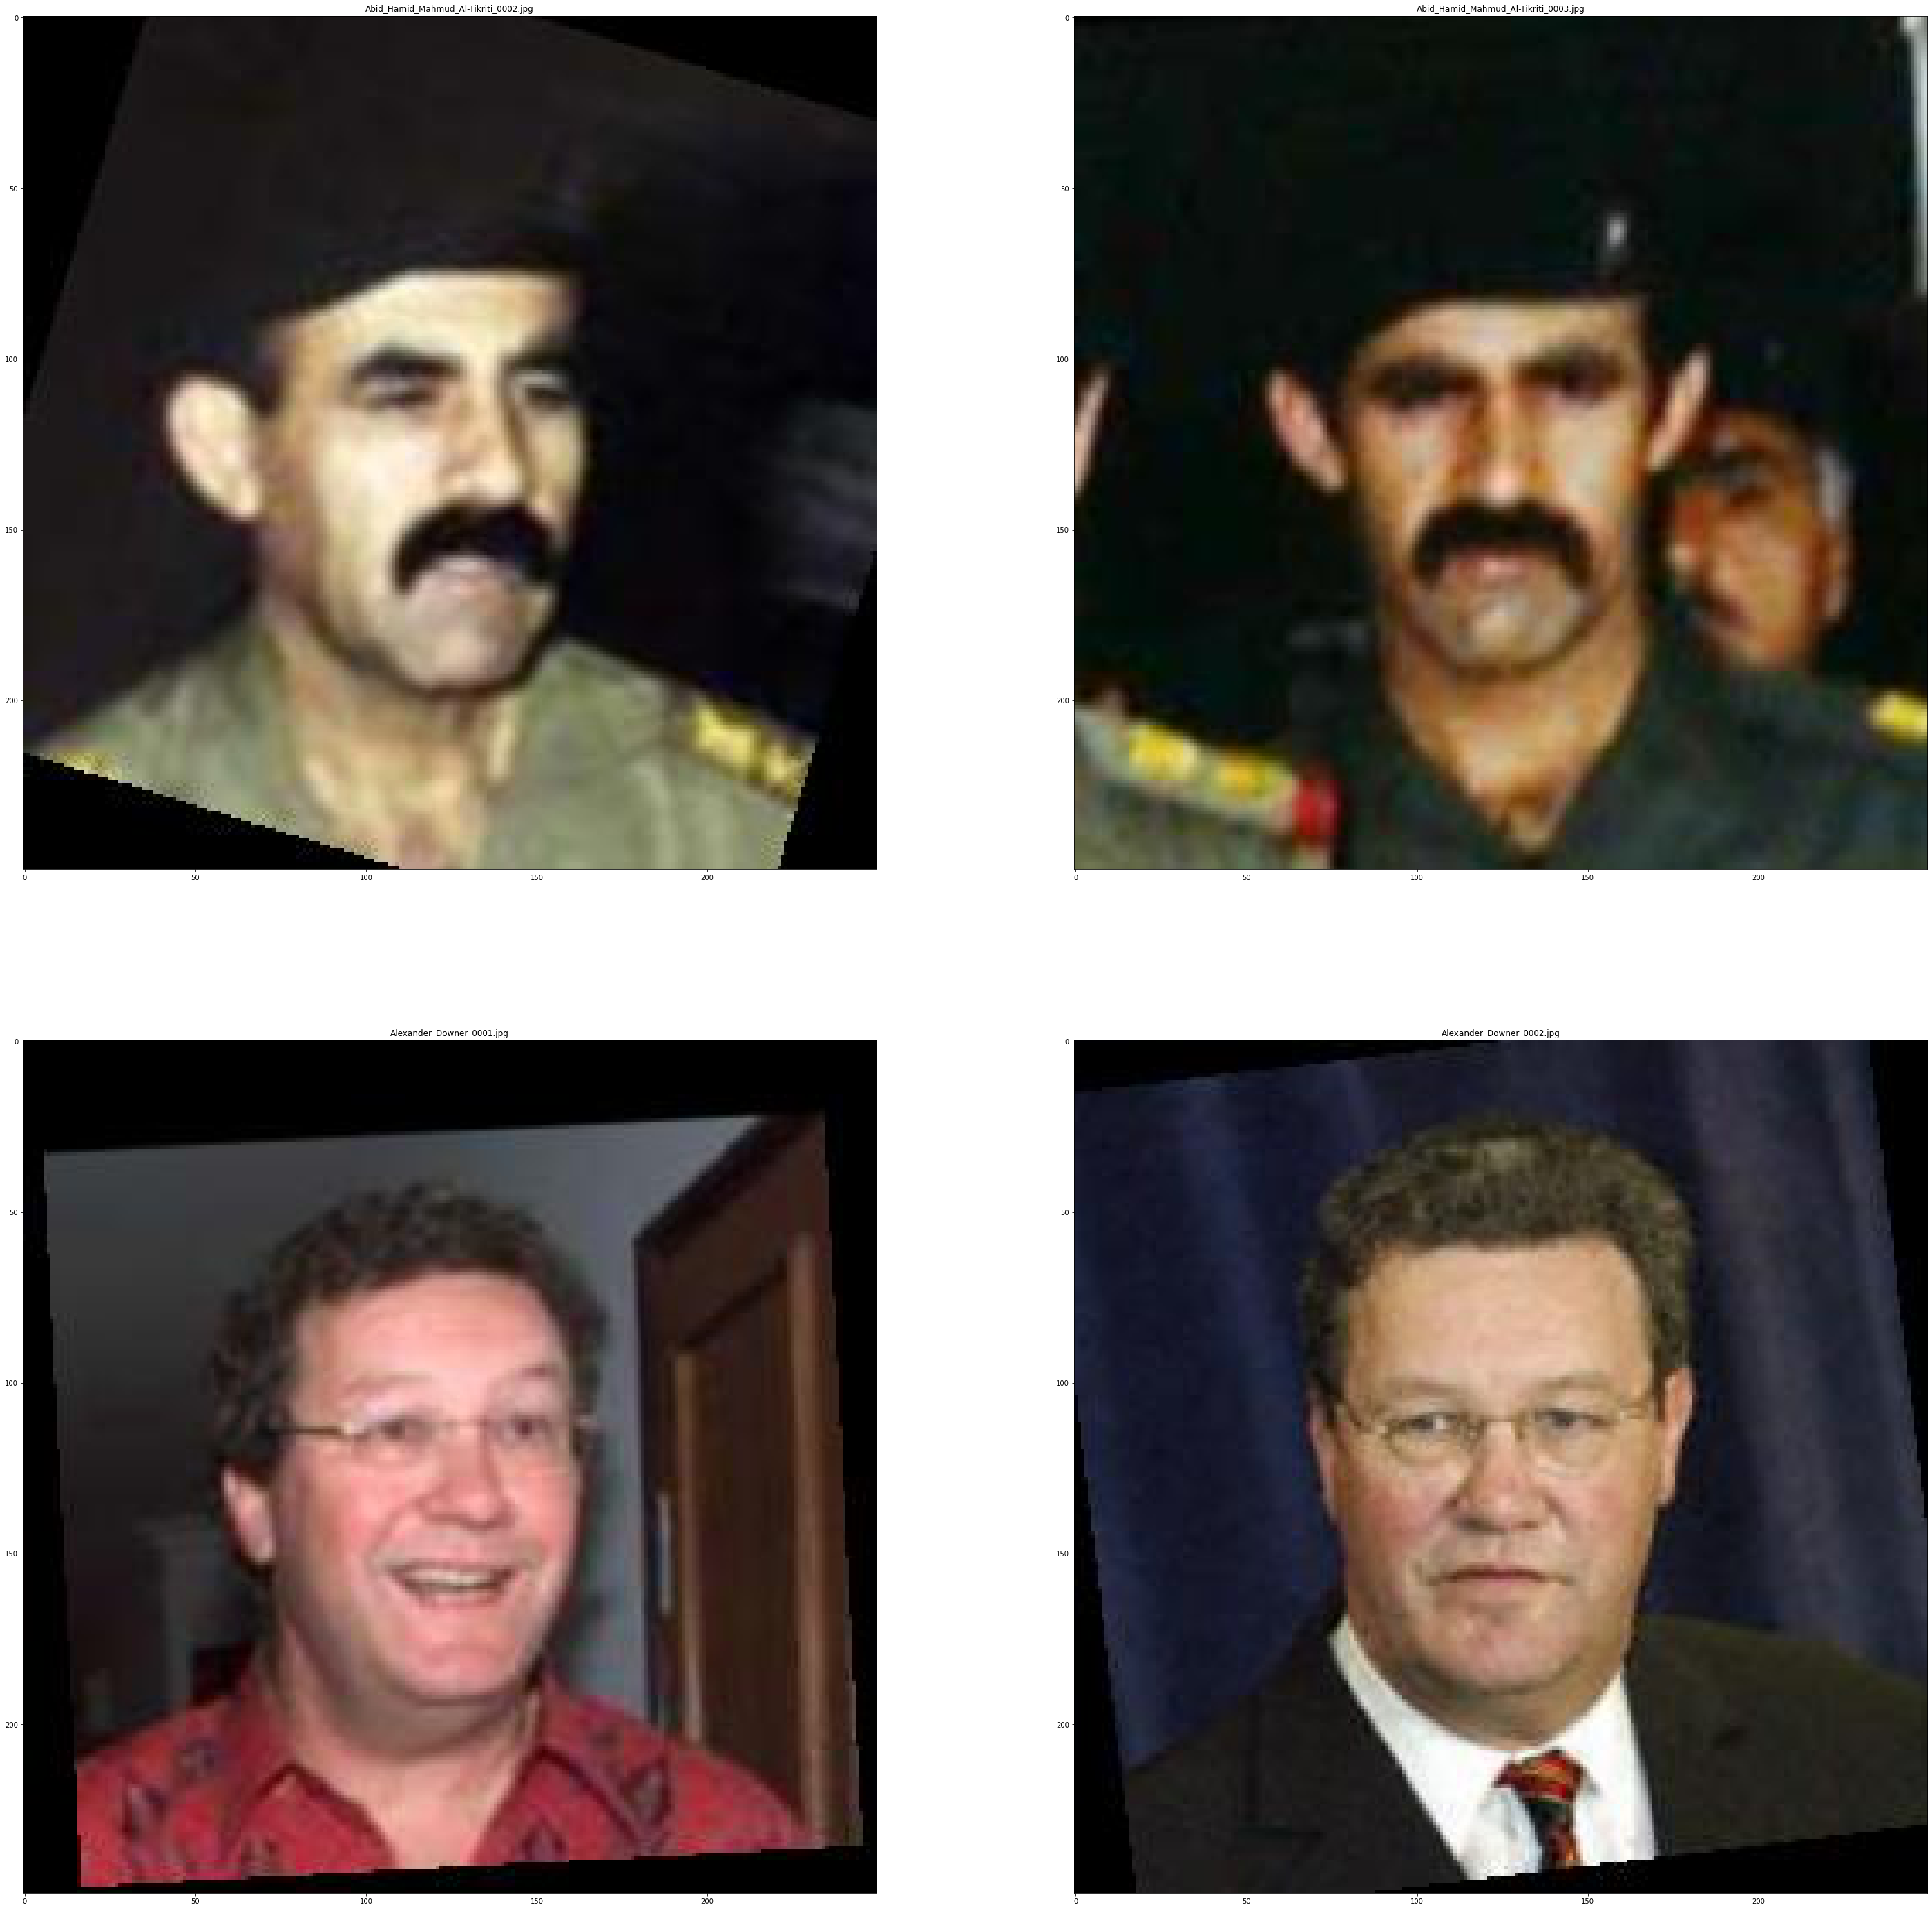

['/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0001.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0002.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0003.jpg', '/tmp/dataset/train/Alexander_Downer/Alexander_Downer_0001.jpg', '/tmp/dataset/train/Alexander_Downer/Alexander_Downer_0002.jpg', '/tmp/dataset/train/Alexander_Downer/Alexander_Downer_0003.jpg', '/tmp/dataset/train/Alexander_Downer/Alexander_Downer_0004.jpg', '/tmp/dataset/train/Ali_Khamenei/Ali_Khamenei_0001.jpg', '/tmp/dataset/train/Ali_Khamenei/Ali_Khamenei_0002.jpg', '/tmp/dataset/train/Ali_Khamenei/Ali_Khamenei_0003.jpg', '/tmp/dataset/train/Angelo_Reyes/Angelo_Reyes_0001.jpg', '/tmp/dataset/train/Angelo_Reyes/Angelo_Reyes_0002.jpg', '/tmp/dataset/train/Angelo_Reyes/Angelo_Reyes_0003.jpg', '/tmp/dataset/train/Angelo_Reyes/Angelo_Reyes_0004.jpg', '/tmp/dataset/train/Art_Howe/Art_Howe_0001.jpg', '/tmp/dataset/train/Art_

In [39]:
train_list = get_image_list_from_folder('/tmp/dataset/train/')
plot_images(10, 10, 50, 50, train_list, 2, 2)
print(train_list)

In [40]:
MASKTHE_FACE_PATH="/content/MaskTheFace/"

In [41]:
# extract a single face from a given photograph
def process_and_save_image(image, filename, required_size=(256, 256)):
    # convert to array
    # image = Image.fromarray(image_pixels)
    # image = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    image = image.resize(required_size)
    # cv2.resize(image, required_size)
    # face_array = asarray(image)
    # cv2.imwrite(filename, image)
    # print('processed and saved file ===> ', filename)
    image.save(filename)

Augumenting data ..
total samples = > 278
image size (224, 224)
image size (224, 224)
image size (224, 224)
No keypoints detected on image
No keypoints detected on image
image size (224, 224)
image size (224, 224)
image size (256, 256)
deleted image size /tmp/dataset/train/Vladimiro_Montesinos/Vladimiro_Montesinos_0003_KN95_unmask.jpg (256, 256)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
No keypoints detected on image
image size (224, 224)
image size (224, 224)
No keypoints detected on image
No keypoints detected on image
image size (256, 256)
deleted image size /tmp/dataset/train/Sally_Kirkland/Sally_Kirkland_0003_KN95_unmask.jpg (256, 256)
image size (224, 224)
image size (224, 224)
image size (224, 224)
No keypoints detected on image
No keypoints detected on image
image size (224, 224)
image size (224, 224)
No keypoints detected on image
No keypoints detected on image
image size (224, 224)
image size (224, 224)
image

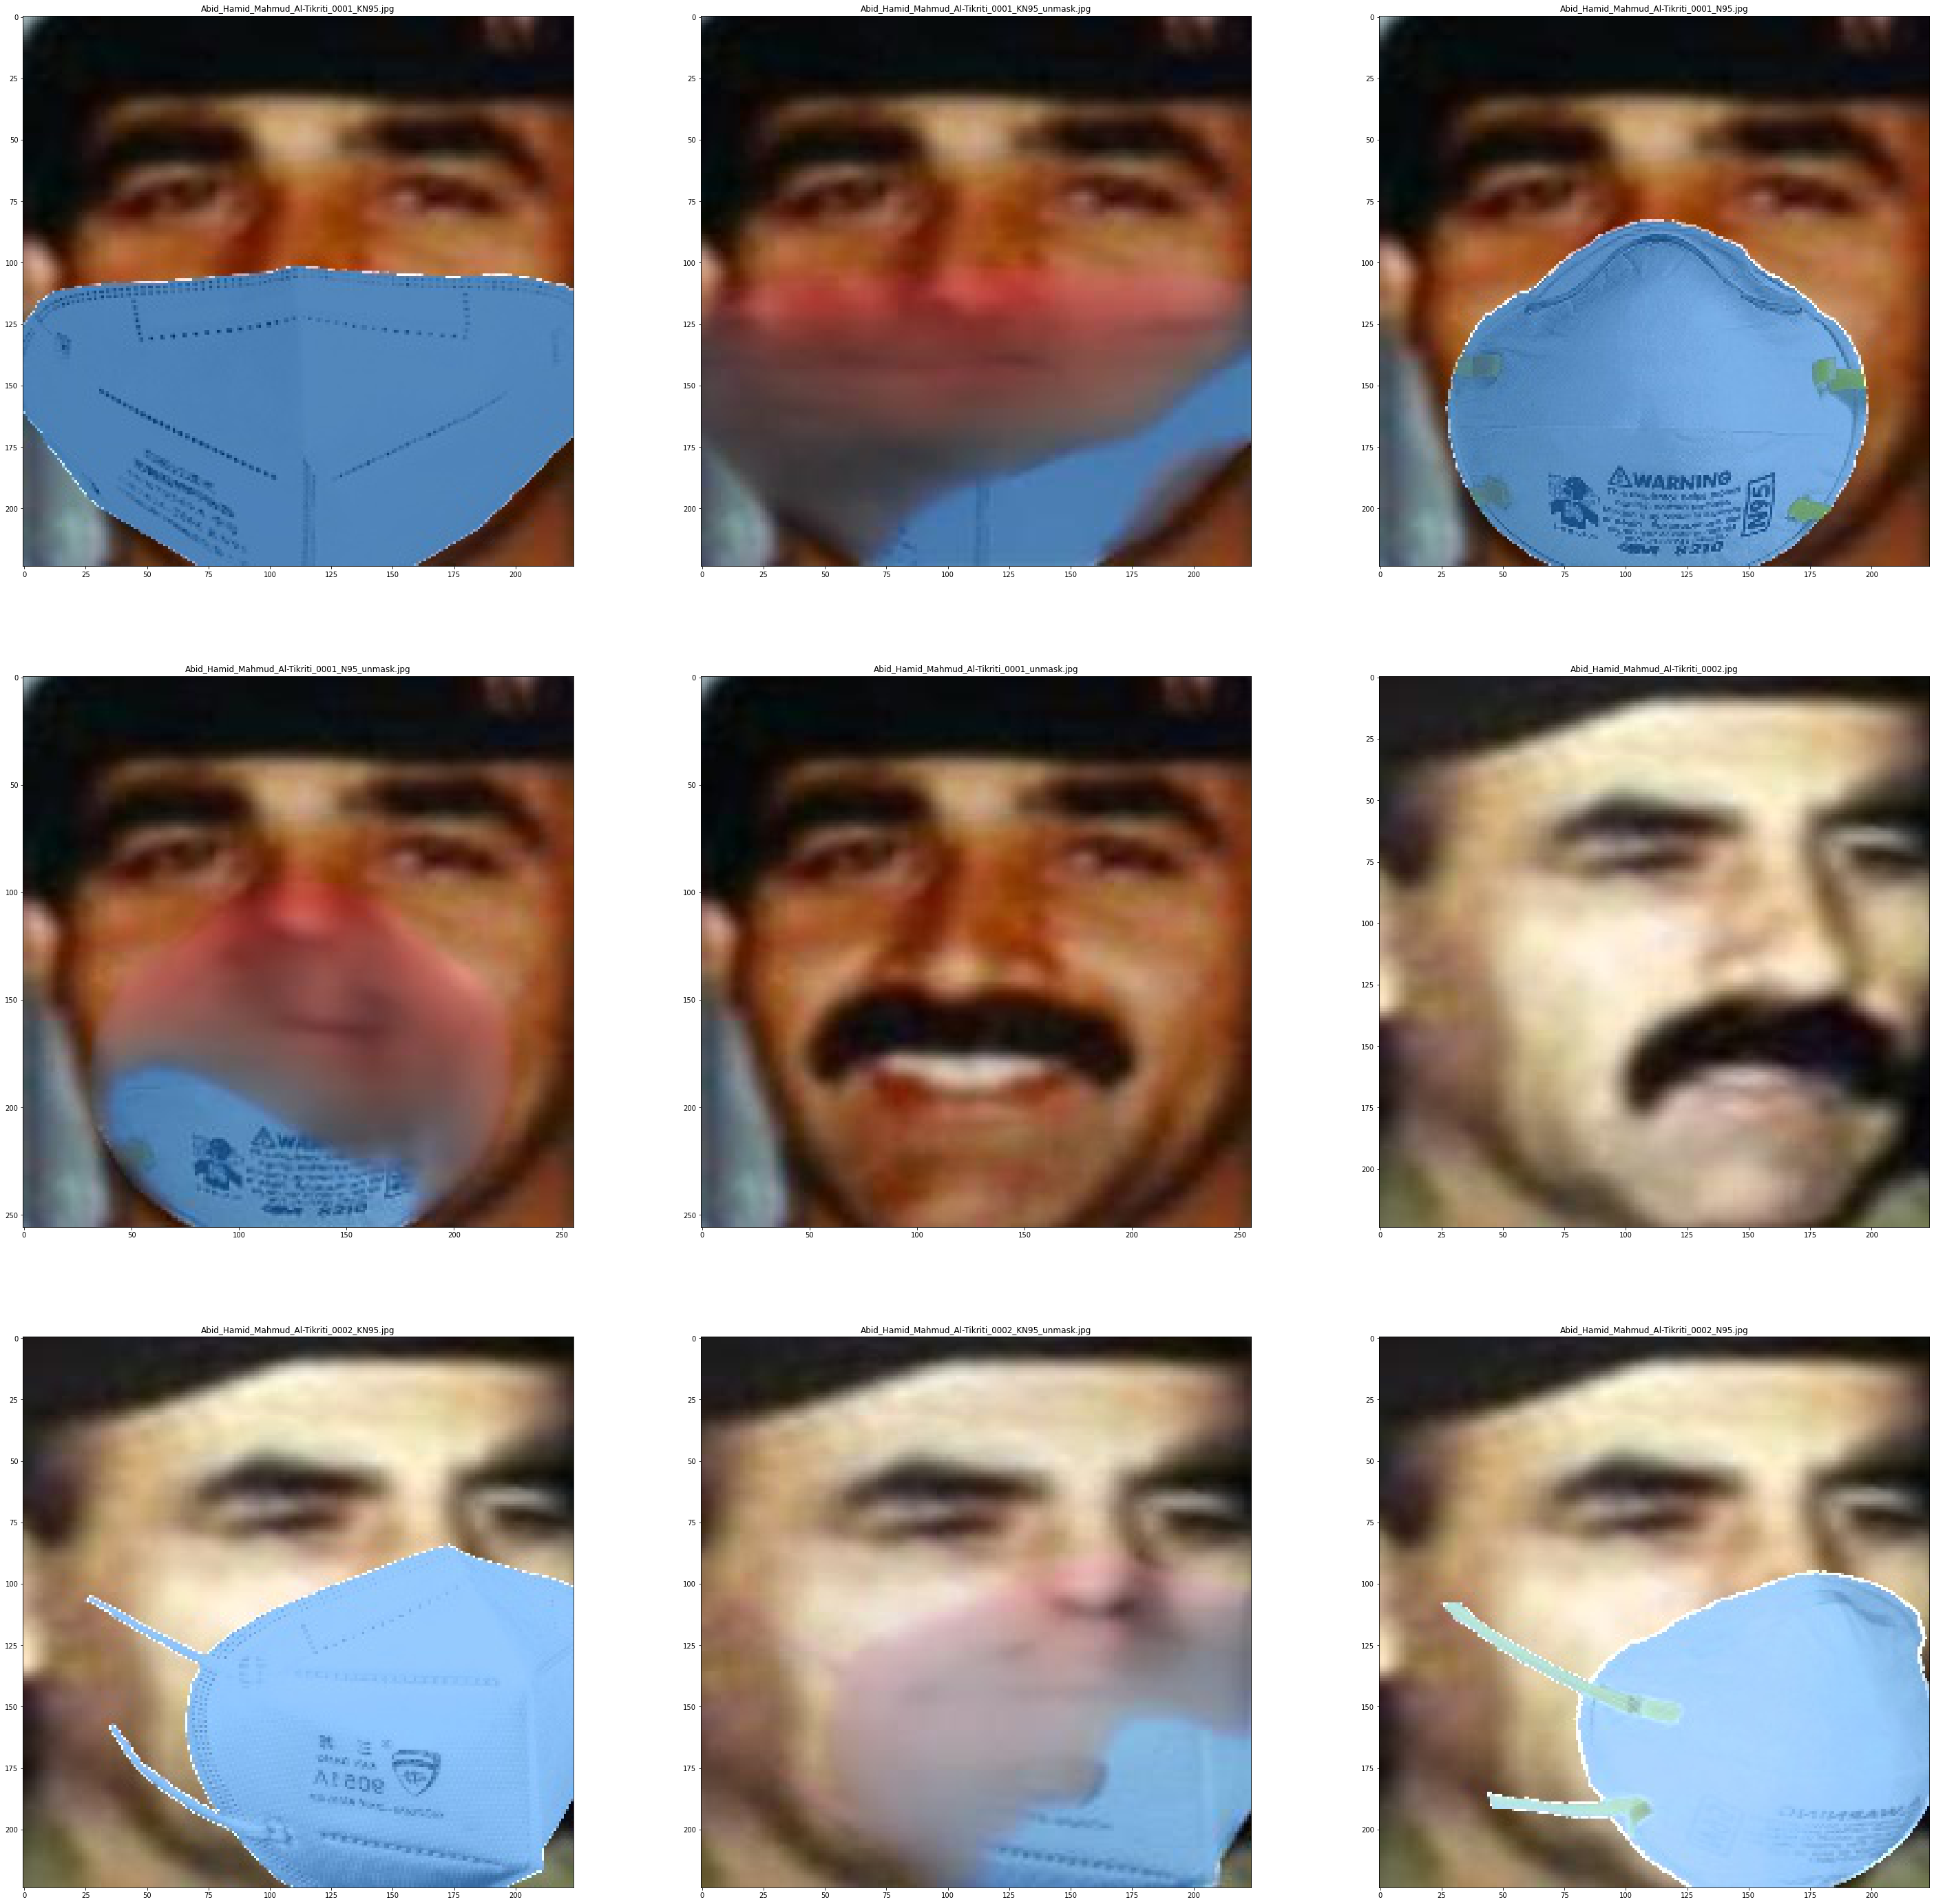

['/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0001.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0001_KN95.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0001_KN95_unmask.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0001_N95.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0001_N95_unmask.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0001_unmask.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0002.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0002_KN95.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0002_KN95_unmask.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0002_N95.jpg', '/tmp/dataset/train/Abid_Hamid_Mahmud_Al-Tikriti/

In [42]:
def augument_mask_data(train_folder, augument):
  triplets = []
  print("Augumenting data ..")
  os.chdir(MASKTHE_FACE_PATH)
  if(augument == 'None'):
    return
  # print("Current path=",os.getcwd())
  # os.system('pip install -r requirements.txt')
  f = [y for y in  Path(train_folder).rglob('*.jpg')] 
  print("total samples = >", len(f))
  for path in  Path(train_folder).rglob('*.jpg'):
    # print(path)
    normal_img_path = str(path)
    process_face(normal_img_path)
    for mask_type in ["Surgical", "N95", "KN95", "Cloth"]:
      subprocess.run(["python", "/content/MaskTheFace/mask_the_face.py",'--path', path, '--mask_type', mask_type, '--verbose', '--write_original_image'])
      files = Path(train_folder).rglob('*.jpg')
      recent_file =  max(files , key=os.path.getctime)
      process_face(recent_file)
      # print("recent file ==>", str(recent_file))
      # model = keras.models.load_model('/content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face/mask2face_siva_trained/')
      # print((recent_file))
      masked_img_path  = str(recent_file)
      if(str(recent_file).find("unmask") == -1 and (augument == 'All')):
        image = Image.open(recent_file)
        # print(image.size)
        image = tf.expand_dims(img_to_array(image), axis=0)  
        # print(image.dim)
        # img_to_array
        # print("=========>", image.shape)
        generated_output = trained_model.predict((recent_file))
        # process_and_save_image(generated_output, recent_file)
        unmask_image_path = Path(recent_file)
        # print("stem ==>", unmask_image_path.stem)
        latest_unmasked_file = str(unmask_image_path.parent) +"/" +unmask_image_path.stem +"_unmask" + unmask_image_path.suffix
        # unmask_image_path.rename(Path(unmask_image_path.parent, latest_unmasked_file))
        # print("latest_unmasked_file", latest_unmasked_file)
        triplets.append([normal_img_path, masked_img_path, str(latest_unmasked_file)])
        # print(type(generated_output))
        # cv2_imshow(generated_output)
        process_and_save_image(generated_output, str(latest_unmasked_file))
      # print("-----------------------------------------------")
  return triplets
augument_mask_data('/tmp/dataset/train/', 'All')
train_list = get_image_list_from_folder('/tmp/dataset/train/')
plot_images(10, 10, 50, 50, train_list, 3, 3)
print(train_list)

image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (112, 112)
deleted image size /tmp/dataset/test/Branko_Crvenkovski/Branko_Crvenkovski_0001_0000.jpg (112, 112)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224)
image size (224, 224

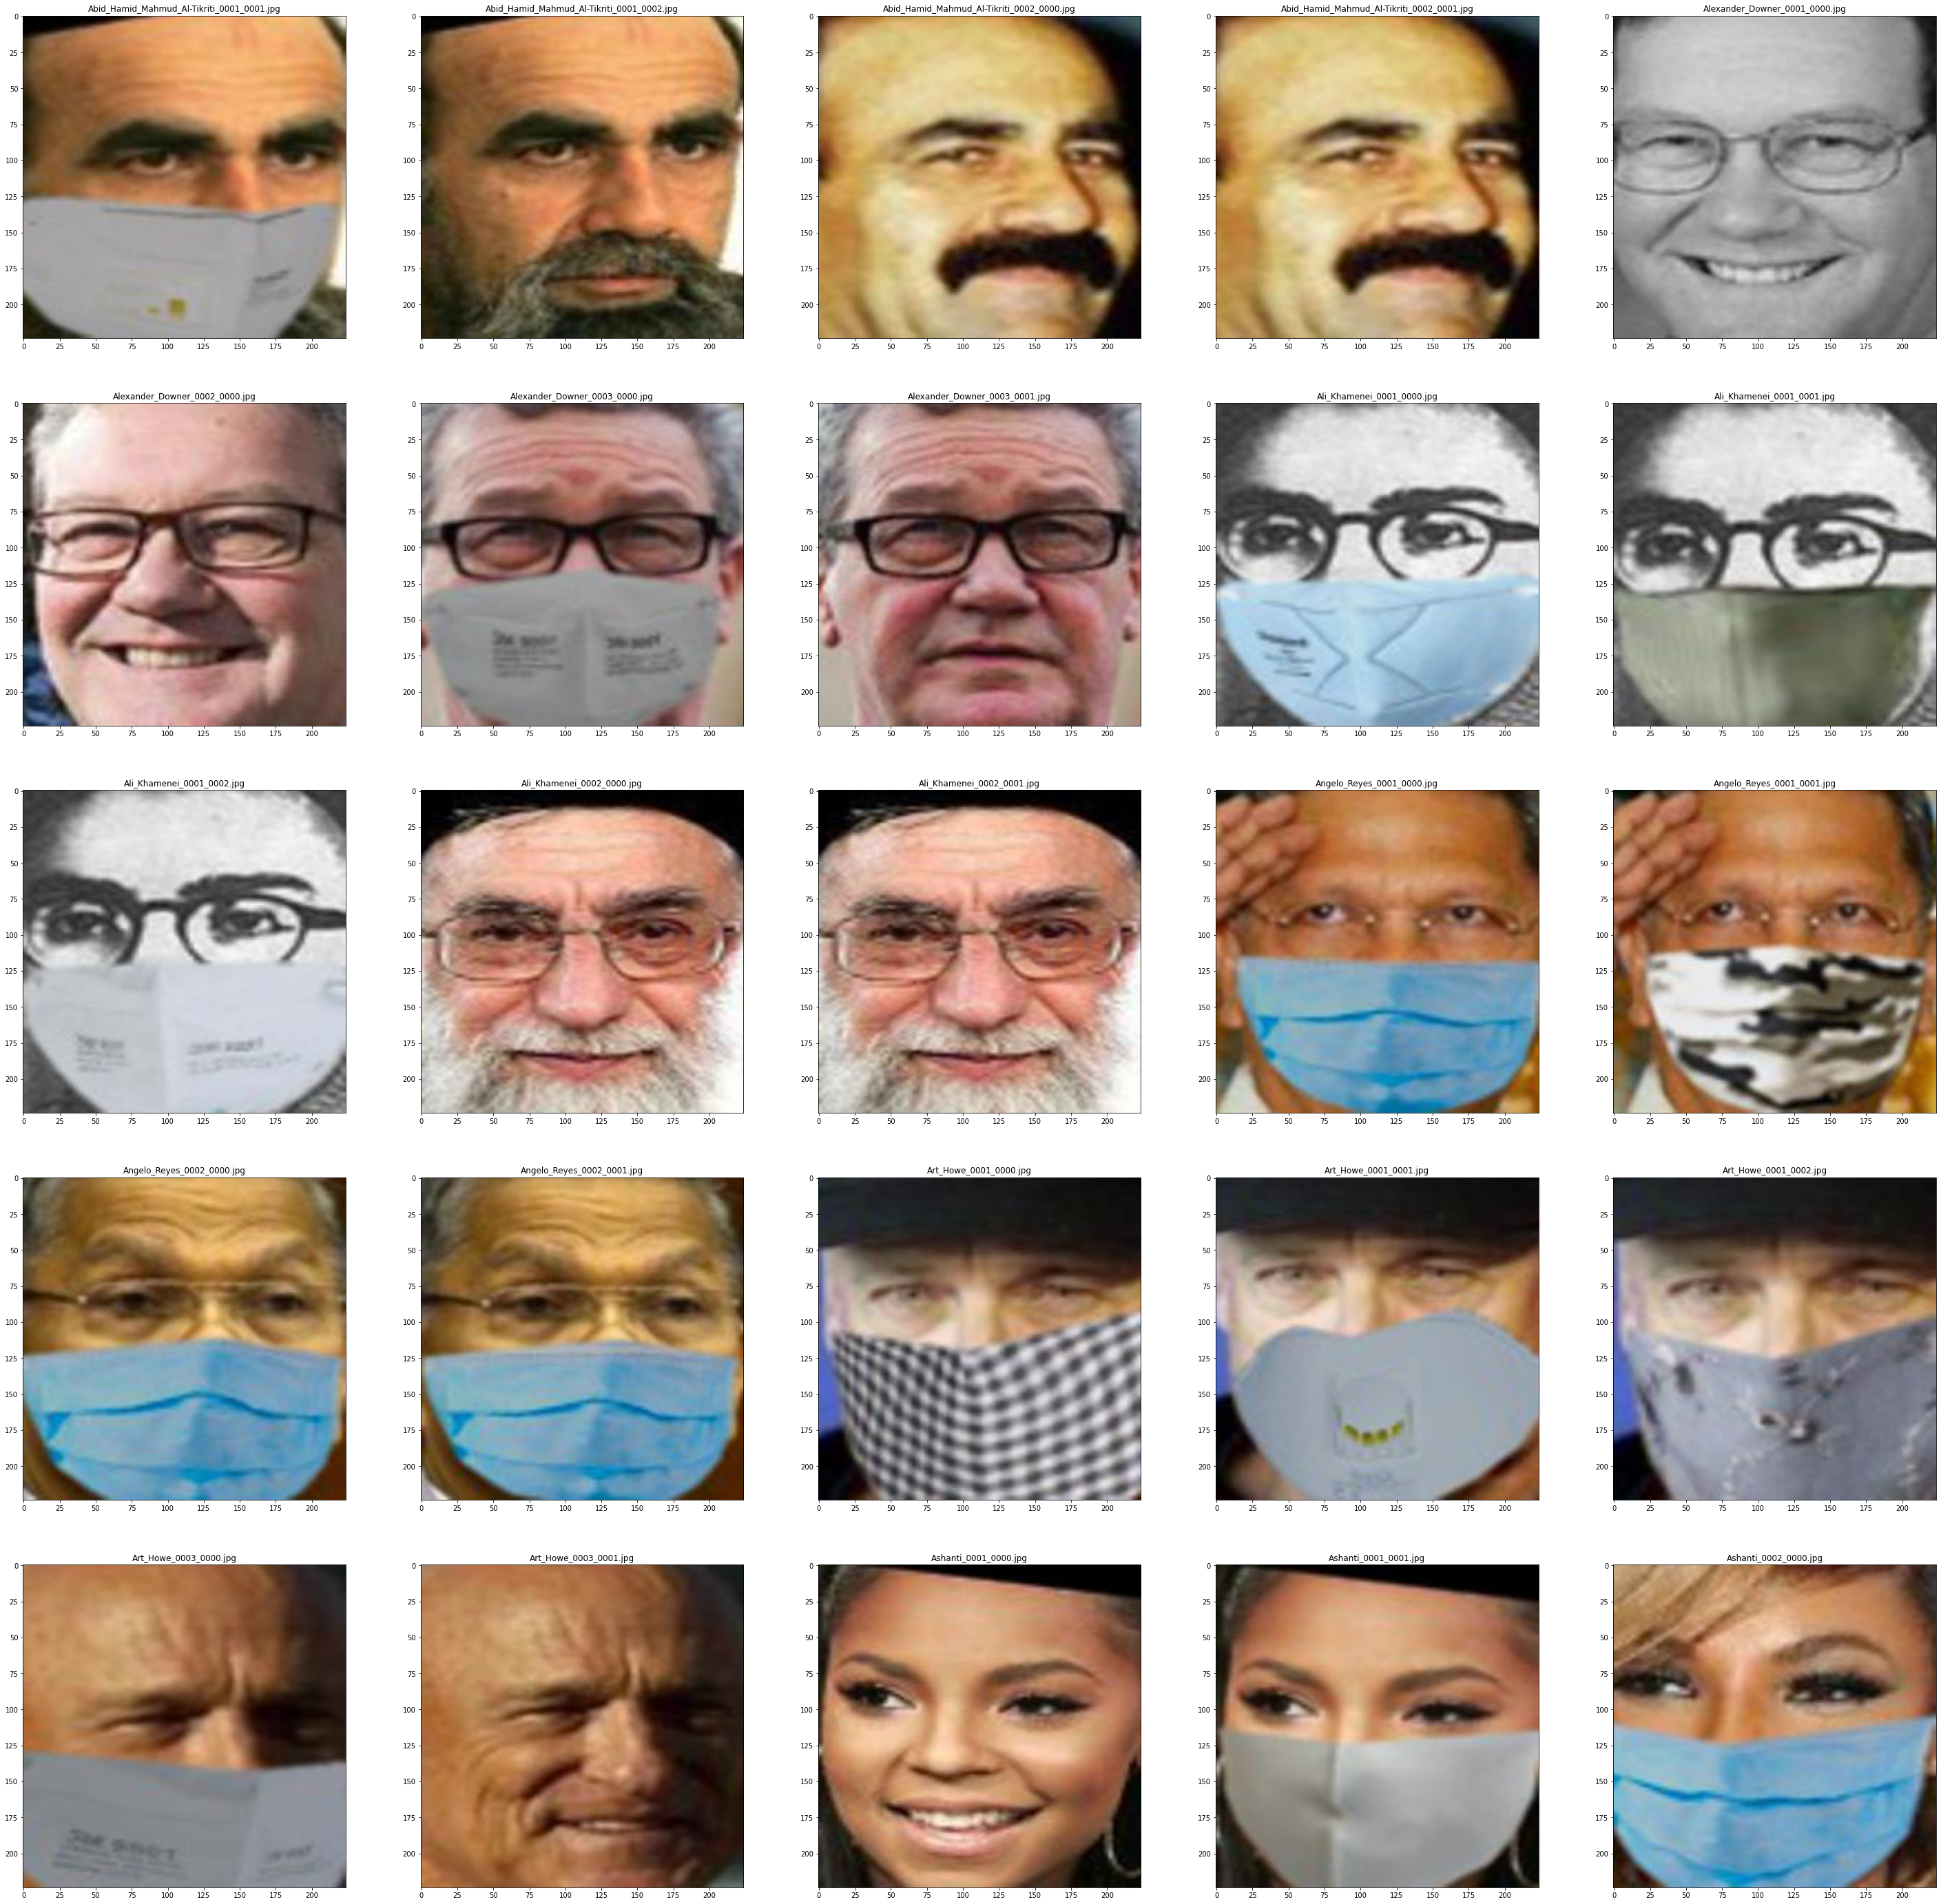

In [43]:
test_list = get_image_list_from_folder('/tmp/dataset/test/')
if(force_create == True):
  process_faces(test_list)
plot_images(10, 10, 50, 50, test_list, 5, 5)

In [44]:
def get_data_list(path):
  img_list = get_image_list_from_folder(path)
  all_images = []
  for file in img_list:
      img = cv2.imread(file)
      img = cv2.resize(img,(160,160))
      all_images.append(img)
  final_name_list = []
  for file in img_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          token = token.split(".",1)[0]
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str) 
  final_name_list = [sub[ : -1] for sub in final_name_list]
  return all_images, final_name_list

In [45]:
def create_dataset():
  newTrainX, trainy = get_data_list('/tmp/dataset/train/')
  newTrainX = asarray(newTrainX)
  newTestX, testy = get_data_list('/tmp/dataset/test/')
  newTestX = asarray(newTestX)
  return newTrainX, asarray(trainy), newTestX, asarray(testy)

In [46]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

In [47]:
def get_train_test_list():
  train_folders = os.listdir("/tmp/dataset/train")
  num_train = int(len(train_folders))
  test_folders = os.listdir("/tmp/dataset/test")
  num_test = int(len(test_folders))
  train_list, test_list = {}, {}

  for folder in train_folders:
      num_files = len(os.listdir(os.path.join("/tmp/dataset/train", folder)))
      train_list[folder] = num_files
  for folder in test_folders:
    num_files = len(os.listdir(os.path.join("/tmp/dataset/test", folder)))
    test_list[folder] = num_files
  return train_list, test_list

train_list, test_list = get_train_test_list()
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 76
Length of testing list : 76

Test List: {'Vladimiro_Montesinos': 4, 'Sally_Kirkland': 5, 'Doris_Schroeder': 3, 'Carlo_Ancelotti': 4, 'Ronald_Reagan': 3, 'Edmund_Hillary': 4, 'Branko_Crvenkovski': 4, 'Art_Howe': 5, 'Filippo_Inzaghi': 5, 'Dale_Earnhardt_Jr': 5, 'Bridgette_Wilson-Sampras': 3, 'Steve_Nash': 4, 'Ashanti': 5, 'Federico_Trillo': 4, 'Toni_Braxton': 3, 'Ronaldo_Luis_Nazario_de_Lima': 4, 'Mikhail_Youzhny': 5, 'Penelope_Cruz': 3, 'Eileen_Coparropa': 4, 'Rita_Wilson': 4, 'William_Bratton': 5, 'Ali_Khamenei': 5, 'Samuel_Waksal': 5, 'Zoran_Djindjic': 4, 'Woody_Allen': 3, 'Jesse_Ventura': 4, 'Ranil_Wickremasinghe': 4, 'John_Reid': 5, 'Kristen_Breitweiser': 4, 'Ethan_Hawke': 3, 'Vitali_Klitschko': 5, 'Christine_Baumgartner': 2, 'Robert_Bonner': 4, 'Pupi_Avati': 4, 'Hitomi_Soga': 3, 'Sourav_Ganguly': 3, 'Fred_Thompson': 2, 'Abid_Hamid_Mahmud_Al-Tikriti': 5, 'Prince_Claus': 3, 'Franz_Muentefering': 4, 'Iain_Duncan_Smith': 4, 'Milo_Djukanovic': 5, 'Jorge_Batll

In [48]:
def rename_file_names(path):
  train_folders = os.listdir(path)
  for folder in train_folders:
    i = 0
    folder_path = os.path.join(path, folder)
    for file in os.listdir(folder_path):
      os.rename(folder_path + '/' +file, (folder_path + '/' +str(i) +'.jpg'))
      i = i + 1

In [49]:
if(force_create == True):
  rename_file_names("/tmp/dataset/train")
  rename_file_names("/tmp/dataset/test")

In [50]:
def create_triplets(directory, folder_list, max_files=100):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

# New Section

In [51]:
train_triplet = create_triplets('/tmp/dataset/train', train_list)
test_triplet  = create_triplets('/tmp/dataset/test', test_list)
print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 13262
Number of testing triplets : 485

Examples of triplets:
(('William_Bratton', '8.jpg'), ('William_Bratton', '17.jpg'), ('LeBron_James', '11.jpg'))
(('Woody_Allen', '8.jpg'), ('Woody_Allen', '17.jpg'), ('Cecilia_Bolocco', '1.jpg'))
(('Muhammad_Saeed_al-Sahhaf', '18.jpg'), ('Muhammad_Saeed_al-Sahhaf', '19.jpg'), ('Federico_Trillo', '9.jpg'))
(('Helen_Clark', '9.jpg'), ('Helen_Clark', '19.jpg'), ('Dean_Barkley', '15.jpg'))
(('Kristen_Breitweiser', '4.jpg'), ('Kristen_Breitweiser', '15.jpg'), ('Sally_Kirkland', '7.jpg'))


**Creating Batch-Generator**

Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

Batch_size: Batch_size of the data to return
Preprocess: Whether to preprocess the data or not

In [52]:
def get_batch(triplet_list, path, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor  = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a, path))
            positive.append(read_image(p, path))
            negative.append(read_image(n, path))
            j+=1

      
        anchor =  np.array(anchor)
        positive =  np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

       
        result = [anchor, positive, negative]
        yield (result)

**Plotting the Data**

Plotting the data generated from get_batch() to see the results

In [53]:
from keras.preprocessing.image import img_to_array
def read_image(index, img_path):
    path = os.path.join(img_path, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(image.shape[0] != INPUT_IMAGE_SHAPE):
      image = cv2.resize(image.astype(np.uint8), (INPUT_IMAGE_SHAPE, INPUT_IMAGE_SHAPE))
    return np.array(image)

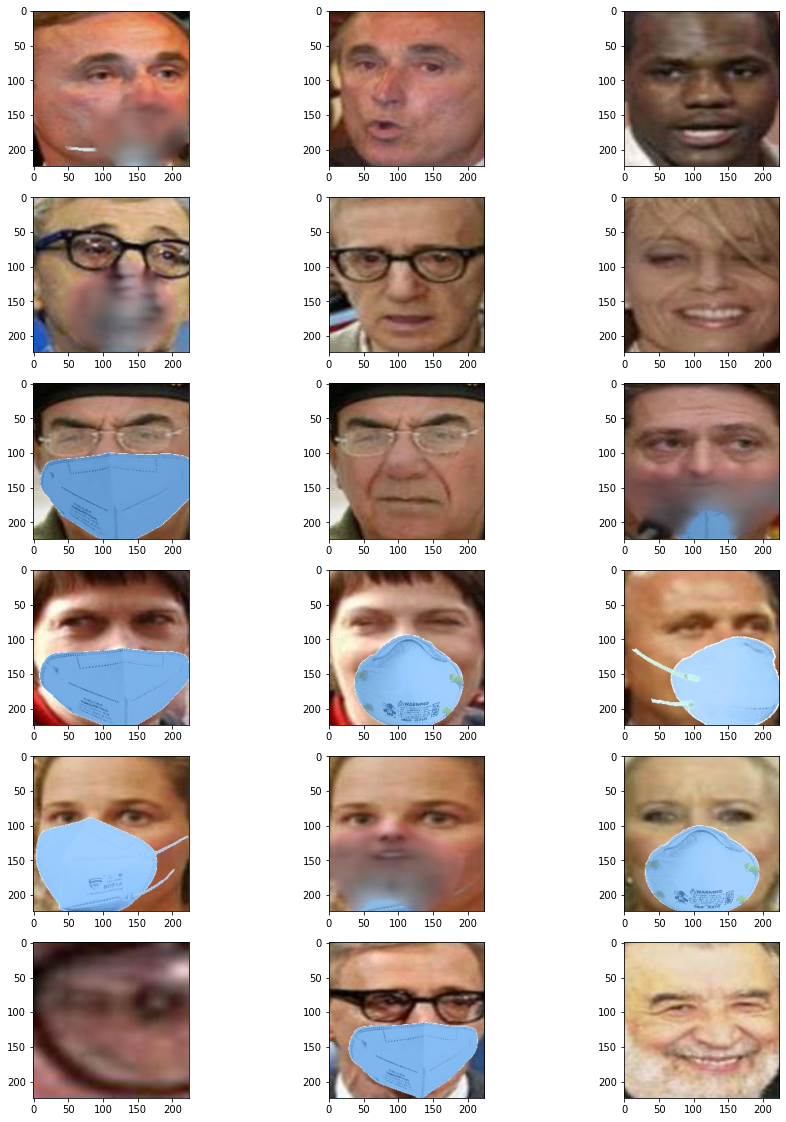

In [54]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet,'/tmp/dataset/train', batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

**Creating the Model**

Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

In [55]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

**Encoder**

The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [56]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    # pretrained_model =tf.keras.applications.resnet50.ResNet50(
    #   include_top=True,
    #   weights='imagenet',
    #   input_tensor=None,
    #   input_shape=None,
    #   pooling=None,
    #   classes=1000
    # )

    # pretrained_model = tf.keras.applications.MobileNetV3Small(
    #       input_shape=None,
    #       alpha=1.0,
    #       minimalistic=False,
    #       include_top=True,
    #       weights="imagenet",
    #       input_tensor=None,
    #       classes=1000,
    #       pooling=None,
    #       dropout_rate=0.2,
    #       classifier_activation="softmax",
    #       include_preprocessing=True,
    #   )

    
    # for i in range(len(pretrained_model.layers)):
    #     pretrained_model.layers[i].trainable = False

    # encode_model = Sequential([
    #     pretrained_model,
    #     layers.Flatten(),
    #     layers.Dense(512, activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.Dense(256, activation="relu"),
    #     layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    # ], name="Encode_Model")

    base_cnn = tf.keras.applications.resnet50.ResNet50(
      weights="imagenet", input_shape= (224,224,3), include_top=False)

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    encode_model = Model(base_cnn.input, output, name="Encode_Model")

    trainable = False
    for layer in base_cnn.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable

    return encode_model

In [57]:
# def get_encoder(input_shape):
#     """ Returns the image encoding model """

#     pretrained_model = Xception(
#         input_shape=input_shape,
#         weights='imagenet',
#         include_top=False,
#         pooling='avg',
#     )
    
#     for i in range(len(pretrained_model.layers)-27):
#         pretrained_model.layers[i].trainable = False

#     encode_model = Sequential([
#         pretrained_model,
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dense(256, activation="relu"),
#         layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
#     ], name="Encode_Model")
#     return encode_model

In [58]:
# pretrained_model_1 = Xception(
#       input_shape=(128,128, 3),
#       weights='imagenet',
#       include_top=False,
#       pooling='avg',
#   )
# # pretrained_model_1.summary()
# len(pretrained_model_1.layers)

In [59]:
# test_pretrained_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000
# )

# print(len(test_pretrained_model.layers))
# # test_pretrained_model.summary()

**Siamese Network**

We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

In [60]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (INPUT_IMAGE_SHAPE, INPUT_IMAGE_SHAPE, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 224, 224, 3  0           []                               
                   

In [61]:
# Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from (siamese_network, show_shapes=True, show_layer_names=True)

**Putting everything together**

We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

In [62]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [63]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

**Training the Model**

We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

**Test Function**

test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [64]:
def test_on_triplets(path, batch_size = 256):
    pos_scores, neg_scores = [], []

    # print(test_triplet)
    for data in get_batch(test_triplet, path, batch_size=batch_size, preprocess=False):
        
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [65]:
save_all = False
epochs = 50
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    #Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, '/tmp/dataset/train', batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets('/tmp/dataset/test', batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 145 sec)
Loss on train    = 0.75674
Accuracy on test = 0.61649

EPOCH: 2 	 (Epoch done in 133 sec)
Loss on train    = 0.40127
Accuracy on test = 0.64742

EPOCH: 3 	 (Epoch done in 133 sec)
Loss on train    = 0.18980
Accuracy on test = 0.67835

EPOCH: 4 	 (Epoch done in 133 sec)
Loss on train    = 0.11938
Accuracy on test = 0.63918

EPOCH: 5 	 (Epoch done in 133 sec)
Loss on train    = 0.08537
Accuracy on test = 0.65567

EPOCH: 6 	 (Epoch done in 134 sec)
Loss on train    = 0.07910
Accuracy on test = 0.64948

EPOCH: 7 	 (Epoch done in 133 sec)
Loss on train    = 0.06258
Accuracy on test = 0.65979

EPOCH: 8 	 (Epoch done in 133 sec)
Loss on train    = 0.06156
Accuracy on test = 0.62680

EPOCH: 9 	 (Epoch done in 133 sec)
Loss on train    = 0.05764
Accuracy on test = 0.64948

EPOCH: 10 	 (Epoch done in 133 sec)
Loss on train    = 0.08744
Accuracy on test = 0.63299

EPOCH: 11 	 (Epoch done in 132 sec)
Loss on train    = 0.14255
Accuracy on test = 0.64124

EPOCH: 

**Evaluating the Model**

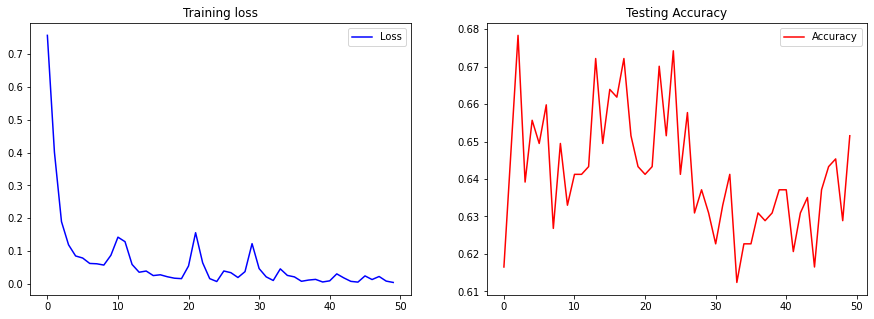

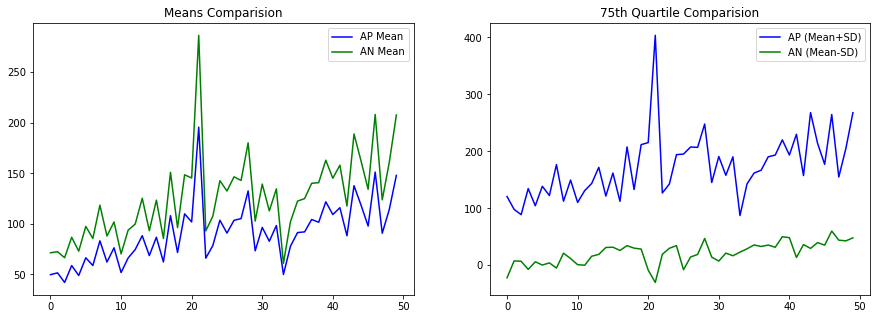

In [66]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

**Using the Model**

Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for latter use.

In [67]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2638 (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2638[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                       

**Classify Images¶**

To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [68]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.537109375



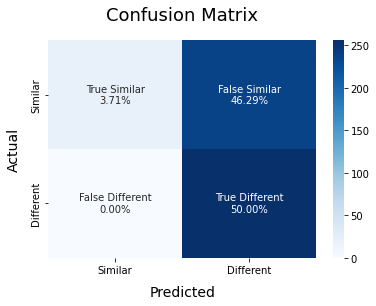

In [69]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet,'/tmp/dataset/test', batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)